# Saddle plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import bioframe

import cooler

import cooltools
import cooltools.eigdecomp
import cooltools.expected
import cooltools.saddle

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2, processes=2)
client = Client(cluster)

In [3]:
# download a Hi-C dataset from Schwarzer et.al. "Two independent modes of chromosome organization are revealed by cohesin removal", 2017

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE93nnn/GSE93431/suppl/GSE93431_NIPBL.200kb.cool.HDF5.gz -O /tmp/GSE93431_NIPBL.200kb.cool.gz
!gunzip -f /tmp/GSE93431_NIPBL.200kb.cool.gz

--2019-10-30 15:16:16--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE93nnn/GSE93431/suppl/GSE93431_NIPBL.200kb.cool.HDF5.gz
           => ‘/tmp/GSE93431_NIPBL.200kb.cool.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE93nnn/GSE93431/suppl ... done.
==> SIZE GSE93431_NIPBL.200kb.cool.HDF5.gz ... 37884973
==> PASV ... done.    ==> RETR GSE93431_NIPBL.200kb.cool.HDF5.gz ... done.
Length: 37884973 (36M) (unauthoritative)

GSE93431_NIPBL.200k 100%[===================>]  36.13M  14.8MB/s    in 2.4s    

2019-10-30 15:16:19 (14.8 MB/s) - ‘/tmp/GSE93431_NIPBL.200kb.cool.gz’ saved [37884973]



In [4]:
coolpath = '/tmp/GSE93431_NIPBL.200kb.cool'
c = cooler.Cooler(coolpath)

In [5]:
# Define continuous genomic regions for calculations of contact frequency decay 
# with distance (aka "expected").
# Typically, we calculate expected separately for each chromosomal arm because
# centromeres additionally suppress contacts accross themselves.
# In mice, chromosomes are acrocentric and expected can be calculated 
# for whole chromosomes.

regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames]

In [6]:
# Download and compute gene count per genomic bin 

bins = c.bins()[:]
genecov = bioframe.tools.frac_gene_coverage(bins, 'mm9')

In [7]:
# Perform eigenvector decomposition in cis, sorting and flipping eigenvectors 
# according to their correlation with the number of genes in each bin.

cis_eigs = cooltools.eigdecomp.cooler_cis_eig(
    c, 
    genecov, 
    regions=None, 
    n_eigs=5, 
    phasing_track_col='gene_count')

Text(0.5, 0, 'chr1 position, bp')

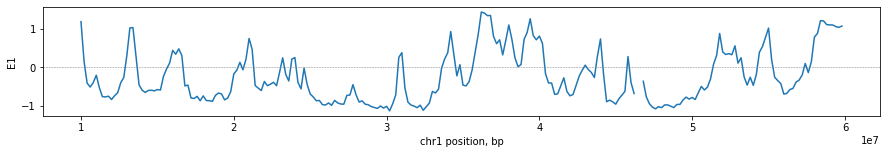

In [8]:
# Plot eigenvectors to confirm successful eigenvector decomposition.

plt.figure(
    figsize=(15,2)
)

loc_eig = bioframe.slice_bedframe(cis_eigs[1], 'chr1:10M-60M')
plt.plot(
    loc_eig['start'],
    loc_eig['E1']
)
plt.axhline(0,ls='--',lw=0.5,color='gray')
plt.ylabel('E1')
plt.xlabel('chr1 position, bp')

In [9]:
# Digitize eigenvectors, i.e. group genomic bins into 
# equisized groups according to their eigenvector rank.

Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
q_edges = np.linspace(Q_LO, Q_HI, N_GROUPS+1)

# Filter track used for grouping genomic bins based on bins filtered out in Hi-C balancing weights
# Doesn't do anything with eigenvectors from the same Hi-C data (hence commented out here),
# but important for external data, such as ChIP-seq tracks
#eig = cooltools.saddle.mask_bad_bins((cis_eigs[1], 'E1'), (c.bins()[:], 'weight'))

# Calculate the lower and the upper values of E1 in each of 38 groups.
group_E1_bounds = cooltools.saddle.quantile(eig['E1'], q_edges)

# Assign the group to each genomic bin according to its E1, i.e. "digitize" E1.
digitized, hist = cooltools.saddle.digitize_track(
    group_E1_bounds,
    track=(eig, 'E1'),
)

Text(0.5, 0, 'chr1 position, bp')

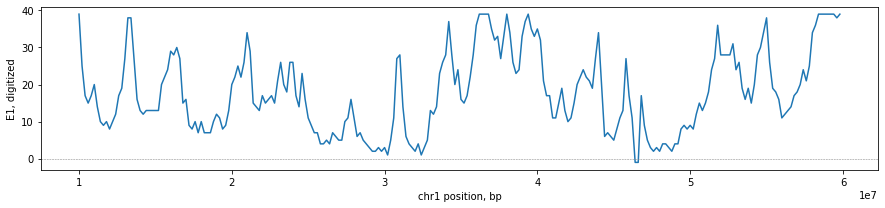

In [10]:
# Plot the digitized E1 to confirm that digitization was successful.

plt.figure(
    figsize=(15,3)
)

loc_eig = bioframe.slice_bedframe(digitized, 'chr1:10M-60M')
plt.plot(
    loc_eig['start'],
    loc_eig['E1.d']
)
plt.axhline(0,ls='--',lw=0.5,color='gray')
plt.ylabel('E1, digitized')
plt.xlabel('chr1 position, bp')

In [11]:
# Calculate the decay of contact frequency with distance (i.e. "expected")
# for each chromosome.

expected = cooltools.expected.cis_expected(c, regions, use_dask=True)

# Make a function that returns observed/expected dense matrix of an arbitrary
# region of the Hi-C map.
getmatrix = cooltools.saddle.make_cis_obsexp_fetcher(c, (expected, 'balanced.avg'))

In [12]:
# Compute the saddle plot, i.e. the average observed/expected between genomic 
# ins as a function of their digitized E1.

S, C = cooltools.saddle.make_saddle(
    getmatrix,
    group_E1_bounds,
    (digitized, 'E1' + '.d'),
    contact_type='cis')

/home/s1529682/Projects/cooltools/cooltools/saddle.py:144: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat/exp_mat
/home/s1529682/Projects/cooltools/cooltools/saddle.py:144: RuntimeWarning: divide by zero encountered in true_divide
  return obs_mat/exp_mat


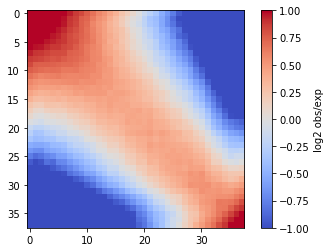

In [13]:
plt.imshow(
    np.log2(S / C)[1:-1, 1:-1],
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    
)
plt.colorbar(label='log2 obs/exp') 